# Classifying Dog Breeds with Image Classification on Sagemaker

In this project, we will be classifying dog images using a pretrained model and deploying it onto AWS Sagemaker as an endpoint.

Before we start, we first have to install and import some libraries.

In [22]:
# Install any packages that you might need
!pip install smdebug --upgrade

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [23]:
# Import all necessary packages
import sagemaker
from sagemaker.session import Session
import boto3
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Dataset

For this project, we will classifying dog breeds using a [labeled dataset of dog images](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip) to train an ML model. Before we train our model, however, it is important that we examine our data to look for important features and determine if we need to modify the images. 

To start, we'll download our data set:

In [24]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-02-12 02:48:43--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.208
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  20.6MB/s    in 45s     

2022-02-12 02:49:30 (24.0 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

One thing to note is the presence of three subdirectories directly one level below the uppermost `.dogImages`:
* `./train`
* `./valid`
* `./test`

We can also see that there are different photos in each subdirectory. With those observations, it is clear that the images are already split into sets for our classification model. This will be especially helpful when training.

**NOTE:** One thing that came up occasionally while working on this notebook was that there would be some dotfiles that got created in `.dogImages`. To prevent them from being accidentally fed into our machine learning model, I've had to run the following cell sometimes.

In [26]:
!rm -r .dogImages/train/.ipynb_checkpoints
!rm -r .dogImages/valid/.ipynb_checkpoints
!rm -r .dogImages/test/.ipynb_checkpoints

rm: cannot remove '.dogImages/train/.ipynb_checkpoints': No such file or directory
rm: cannot remove '.dogImages/valid/.ipynb_checkpoints': No such file or directory
rm: cannot remove '.dogImages/test/.ipynb_checkpoints': No such file or directory


Fortunately, it doesn't seem like this folder currently has any `.ipynb_checkpoint` files, so we should be good to proceed with directory analysis.

#### Analyzing the Data

While not required, it will be especially helpful to load the data onto a Pandas DataFrame. This will allow us to analyze the file names and their contents programmatically, especially when calculating aggregations, such as getting counts.

Another benefit of using a DataFrame comes down to the practical limitations of Sagemaker Studio. Personally speaking, working in Sagemaker with a large unzipped directory such as `.dogImages` can cause a lot of lag in the notebook. While working on this project, I initially kept the files in my Sagemaker Studio workspace to examine individual images. However, after I got a I actually found it useful to download the files, load some data about them onto a DataFrame, and then upload them to S3. I would then be able to delete the folder and make my workflow a significantly faster. As long as I didn't reset the kernel, I would still be able to access the file names via DataFrame.

In [27]:
basedir = './dogImages'

arr_train = []
arr_valid = []
arr_test = []

for subdir, dirs, files in os.walk(basedir):
    for file in files:
        path_arr = subdir.split('/')
        folder = path_arr[2]
        label = int(path_arr[3].split('.')[0])
        if (folder == 'train'):
            arr_train.append([label, subdir, file])
        elif (folder == 'valid'):
            arr_valid.append([label, subdir, file])
        elif (folder == 'test'):
            arr_test.append([label, subdir, file])

df_train = pd.DataFrame(arr_train, columns = ['label', 'subdir', 'file']).sort_values(['label', 'file'], ignore_index = True)
df_train['row'] = range(len(df_train))

df_valid = pd.DataFrame(arr_valid, columns = ['label', 'subdir', 'file']).sort_values(['label', 'file'], ignore_index = True)
df_valid['row'] = range(len(df_valid))

df_test = pd.DataFrame(arr_test, columns = ['label', 'subdir', 'file']).sort_values(['label', 'file'], ignore_index = True)
df_test['row'] = range(len(df_test))

With this DataFrame, let's first examine the number of classes in this project. We can do so by counting the number of unique label names.

In [28]:
num_classes = df_train['label'].nunique()
print(f'There are {num_classes} classes in this dataset.')

There are 133 classes in this dataset.


Now, we can check out the images in the three subdirectories. It is worth noting that within a single subdirectory (`./train`, `./valid`, and `./test`), there are 133 subdirectories, each named with a different number and dog breed. This indicates that the photos are already organized and separated into labeled folders, and these directory names corresponding to labels. Earlier, I had gone ahead and extracted the numbers out of the folder names into their own `label` column.

Below, the total counts of the images, as well as a random sample of the images in the training folder are displayed. This will allow us to gain some assurance that all the images are consistently named throughout the different labels.

In [29]:
# Examine a sample of rows of each dataframe
print(f'There are {len(df_train.index)} training images.')
df_train.sample(n = 10, random_state = 1)

There are 6680 training images.


,label,subdir,file,row
2039,36,./dogImages/train/036.Briard,Briard_02553.jpg,2039
250,5,./dogImages/train/005.Alaskan_malamute,Alaskan_malamute_00313.jpg,250
1685,30,./dogImages/train/030.Border_terrier,Border_terrier_02109.jpg,1685
2578,45,./dogImages/train/045.Cardigan_welsh_corgi,Cardigan_welsh_corgi_03224.jpg,2578
5484,103,./dogImages/train/103.Mastiff,Mastiff_06857.jpg,5484
2632,46,./dogImages/train/046.Cavalier_king_charles_sp...,Cavalier_king_charles_spaniel_03292.jpg,2632
5033,93,./dogImages/train/093.Kerry_blue_terrier,Kerry_blue_terrier_06295.jpg,5033
2723,48,./dogImages/train/048.Chihuahua,Chihuahua_03406.jpg,2723
2060,36,./dogImages/train/036.Briard,Briard_02579.jpg,2060
1147,20,./dogImages/train/020.Belgian_malinois,Belgian_malinois_01433.jpg,1147


We can see the same for the validation and testing folders below:

In [30]:
print(f'There are {len(df_valid.index)} validation images.')
df_valid.sample(n = 10, random_state = 1)

There are 835 validation images.


,label,subdir,file,row
822,130,./dogImages/valid/130.Welsh_springer_spaniel,Welsh_springer_spaniel_08240.jpg,822
255,37,./dogImages/valid/037.Brittany,Brittany_02597.jpg,255
238,34,./dogImages/valid/034.Boxer,Boxer_02430.jpg,238
807,128,./dogImages/valid/128.Smooth_fox_terrier,Smooth_fox_terrier_08099.jpg,807
216,31,./dogImages/valid/031.Borzoi,Borzoi_02216.jpg,216
385,55,./dogImages/valid/055.Curly-coated_retriever,Curly-coated_retriever_03885.jpg,385
452,65,./dogImages/valid/065.Entlebucher_mountain_dog,Entlebucher_mountain_dog_04590.jpg,452
453,66,./dogImages/valid/066.Field_spaniel,Field_spaniel_04602.jpg,453
8,2,./dogImages/valid/002.Afghan_hound,Afghan_hound_00095.jpg,8
437,63,./dogImages/valid/063.English_springer_spaniel,English_springer_spaniel_04437.jpg,437


In [31]:
print(f'There are {len(df_test.index)} testing images.')
df_test.sample(n = 10, random_state = 1)

There are 836 testing images.


,label,subdir,file,row
823,130,./dogImages/test/130.Welsh_springer_spaniel,Welsh_springer_spaniel_08215.jpg,823
255,36,./dogImages/test/036.Briard,Briard_02519.jpg,255
238,33,./dogImages/test/033.Bouvier_des_flandres,Bouvier_des_flandres_02328.jpg,238
808,127,./dogImages/test/127.Silky_terrier,Silky_terrier_08057.jpg,808
216,30,./dogImages/test/030.Border_terrier,Border_terrier_02097.jpg,216
385,54,./dogImages/test/054.Collie,Collie_03790.jpg,385
452,63,./dogImages/test/063.English_springer_spaniel,English_springer_spaniel_04440.jpg,452
453,63,./dogImages/test/063.English_springer_spaniel,English_springer_spaniel_04446.jpg,453
8,2,./dogImages/test/002.Afghan_hound,Afghan_hound_00116.jpg,8
437,60,./dogImages/test/060.Dogue_de_bordeaux,Dogue_de_bordeaux_04281.jpg,437


We can see a common trend in the naming system across the entire file path:

```
./dogImages/{model_pipeline_phase_name}/{numeric_label}.{breed}/{breed}_{file_id}.jpg
```

It will be useful for us to have a mapping between label number and species name, so let's create a DataFrame for that:

In [52]:
df_breed_labels = df_train[['label', 'subdir']].copy().drop_duplicates().rename(columns = {'subdir': 'breed'}).set_index('label')
df_breed_labels['breed'] = df_breed_labels['breed'].apply(lambda row: row.split('/')[-1].split('.')[-1].replace('_', ' '))
df_breed_labels.head()

,breed
label,
1,Affenpinscher
2,Afghan hound
3,Airedale terrier
4,Akita
5,Alaskan malamute


Next, let's analyze the individual images. We will use the `PIL` package to examine some images. Because we plan on using a pretrained neural network (specifcally a CNN), it is important that we observe the dimensions of our soon-to-be input images.

This image has a dimension of 500 x 375.


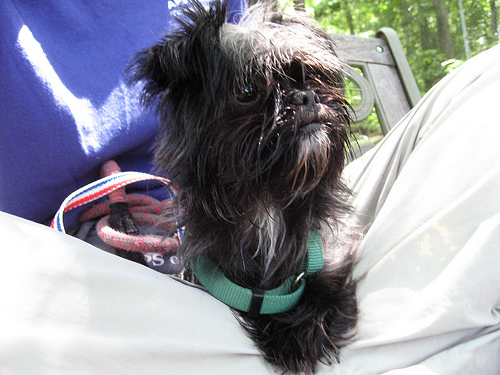

In [53]:
from PIL import Image

sample1 = Image.open(df_train['subdir'].iloc[3] + '/' + df_train['file'].iloc[3])
width1, height1 = sample1.size

print(f'This image has a dimension of {width1} x {height1}.')
display(sample1)

This image has a dimension of 290 x 339.


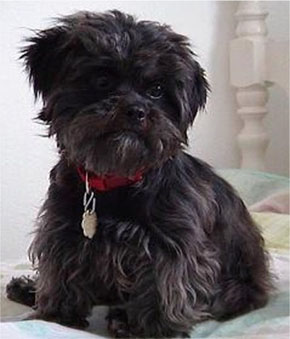

In [54]:
sample2 = Image.open(df_train['subdir'].iloc[48] + '/' + df_train['file'].iloc[48])
width2, height2 = sample2.size

print(f'This image has a dimension of {width2} x {height2}.')
display(sample2)

We can already see between these two images that their dimensions are not identical. This implies that none of the images in the data set have a set height or width, so we will have to make sure to resize them at some point before feeding them into the training the model.

Now that we've analyzed the images, we can go ahead and upload them to S3.

In [55]:
# Set up variables related to AWS account
session = sagemaker.Session()

bucket = session.default_bucket()
print(f'Default Bucket: {bucket}')

region = session.boto_region_name
print(f'AWS Region: {region}')

role = sagemaker.get_execution_role()
print(f'RoleArn: {role}')

Default Bucket: sagemaker-us-east-1-182946999348
AWS Region: us-east-1
RoleArn: arn:aws:iam::182946999348:role/service-role/AmazonSageMaker-ExecutionRole-20220119T202239


In [56]:
# Upload dog images to S3
os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages/train/ s3://${DEFAULT_S3_BUCKET}/data/train/
!aws s3 sync ./dogImages/valid/ s3://${DEFAULT_S3_BUCKET}/data/valid/
!aws s3 sync ./dogImages/test/ s3://${DEFAULT_S3_BUCKET}/data/test/

## Hyperparameter Tuning
In this section, we will finetune a pretrained ResNet18 model with hyperparameter tuning (HPO).

The HPO script can be found in file `hpo.py` and will be the main script use to tune the hyperparameters.

In [57]:
# Some prerequisite inputs
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

The hyperparameters that I have chosen to tune are:
* `lr`, the learning rate of the model's optimizer
* `batch-size`, the number of images that are processed during training before updating the model
* `epochs`, the number of times we will pass the training dataset through our model to update it.

More explanation to why these HP's were selected is discussed in the `README.md` file.

In [58]:
# Declare hyperparameter ranges 
hyperparameter_ranges = {
    'lr': ContinuousParameter(1e-4, 0.1),
    'batch-size': CategoricalParameter([32, 64, 128, 256]),
    'epochs': IntegerParameter(6, 10)
}

Among all of the different hyperparameter combinations that we are trying in training, we want ultimately want to select the model that can perform most accurately on the validation data, a set of images that the model did not "see" while training. We measure this by calculating the how many images in the validation set were labeled correctly by the model that was recently trained. We'll then choose the model with the most correct labels as our best one.

Additionally, we'll keep track of another metric, the average validation loss, across each epoch of hyperparamter tuning.

In [59]:
# Declare metrics for our model
objective_metric_name = 'ValidationNumCorrect'
objective_type = 'Maximize'
metric_definitions = [
    {
        'Name': 'ValidationNumCorrect', 
        "Regex": 'Validation Accuracy: ([0-9]+)'
    },
    {
        'Name': 'ValidationLoss', 
        "Regex": 'Validation Set - Average Loss: ([0-9\\.]+)'
    }
]

With that said, we can now set up a `PyTorch` estimator and a corresponding `HyperparameterTuner`.

In [62]:
# Create an estimator and a corresponding hyperameter tuner
estimator = PyTorch(
    entry_point = 'hpo.py',
    role = role,
    py_version = 'py36',
    framework_version = '1.8',
    instance_count = 1,
    hyperparameters = {
        'num-classes': num_classes
    },
    instance_type = 'ml.g4dn.2xlarge'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs = 10,                    # Up to how many combinations of HP's we want to try in total
    max_parallel_jobs = 2,            # Up to how many HPO jobs we want to run at once
    objective_type = objective_type,
)

Finally, we just need to set up our data channels and then we can fit our tuner and optimize our hyperparamters. 

**NOTE:** This process should take around 1.5 to 3 hours to complete.

In [63]:
# Set up data channels
data_channels = {
    'train': f's3://{bucket}/data/train',
    'valid': f's3://{bucket}/data/valid'
}

# Perform HPO using the tuner
tuner.fit(data_channels)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

After the tuning process is complete, we should be able to download the model whose hyperparameters yieled the lowest validation loss.

In [83]:
# Download the best estimator model from HPO
best_estimator = tuner.best_estimator()

# Display the hyperparameters of the best trained model
tuned_hyperparameters = best_estimator.hyperparameters()
tuned_hyperparameters


2022-02-12 05:21:52 Starting - Preparing the instances for training
2022-02-12 05:21:52 Downloading - Downloading input data
2022-02-12 05:21:52 Training - Training image download completed. Training in progress.
2022-02-12 05:21:52 Uploading - Uploading generated training model
2022-02-12 05:21:52 Completed - Training job completed


{'_tuning_objective_metric': '"ValidationNumCorrect"',
 'batch-size': '"32"',
 'epochs': '10',
 'lr': '0.00037518045557353297',
 'num-classes': '133',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-02-12-03-31-30-487"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-182946999348/pytorch-training-2022-02-12-03-31-30-487/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
Now that we have a set of optimized hyperparameters, we will now create a new `PyTorch` estimator with these values, as well as set up debugging and profiling in this model. For this classifer, we will be using the `train_model.py` script.

In addition to finetuning the model, we'll also be creating some plots later in the project. Therefore, to capture as much useful data as possible, we've kept the validation step in this model. This will be especially useful when comparing the training vs validation loss curves with one another.

In [84]:
# Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, rule_configs, DebuggerHookConfig, CollectionConfig
from sagemaker.debugger import ProfilerRule, ProfilerConfig, FrameworkProfile
from sagemaker.debugger import DetailedProfilingConfig, DataloaderProfilingConfig,PythonProfilingConfig

rules = [
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    Rule.sagemaker(
        base_config = rule_configs.loss_not_decreasing(),
        rule_parameters={'tensor_regex': 'CrossEntropyLoss_output_0'}
    )
]

hook_config = DebuggerHookConfig(
    collection_configs = [
        CollectionConfig(
            name = 'CrossEntropyLoss_output_0',
            parameters = {
                'include_regex': 'CrossEntropyLoss_output_0', 
                'train.save_interval': '25',
                'train.start_step': '1',
                'eval.save_interval': '5',
                'eval.start_step': '1',
            }
        )
    ],
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis = 500, 
    framework_profile_params = FrameworkProfile(
        num_steps = 10,
        detailed_profiling_config = DetailedProfilingConfig(),
        dataloader_profiling_config = DataloaderProfilingConfig(),
        python_profiling_config = PythonProfilingConfig()
    )
)

In [85]:
import re

# Perform some modifications on the hyperparameters to ensure compatibility with the model. This will perform the casting in place.

tuned_hyperparameters = { hp: value for hp, value in tuned_hyperparameters.items() if hp in ['batch-size', 'epochs', 'lr', 'num-classes'] }
tuned_hyperparameters['batch-size'] = int(re.findall('\d+', tuned_hyperparameters['batch-size'])[0])
tuned_hyperparameters['epochs'] = int(tuned_hyperparameters['epochs'])
tuned_hyperparameters['lr'] = float(tuned_hyperparameters['lr'])
tuned_hyperparameters['num-classes'] = int(tuned_hyperparameters['num-classes'])

tuned_hyperparameters

{'batch-size': 32,
 'epochs': 10,
 'lr': 0.00037518045557353297,
 'num-classes': 133}

We can now create a new estimator using our hyperparameters.

In [86]:
# Create an estimator with the hyperparameters from the best estimator
new_estimator = PyTorch(
    entry_point = 'train_model.py',
    role = role,
    py_version = 'py36',
    framework_version = '1.8',
    instance_count = 1,
    hyperparameters = tuned_hyperparameters,
    instance_type = 'ml.g4dn.xlarge',
    rules = rules,
    debugger_hook_config = hook_config,
    profiler_config = profiler_config
)

In [87]:
# Fit the new estimator
input_channels = {
    'train': f's3://{bucket}/data/train',
    'valid': f's3://{bucket}/data/valid',
    'test': f's3://{bucket}/data/test'
}

new_estimator.fit(input_channels, wait = True)

2022-02-12 06:25:09 Starting - Starting the training job...VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
LossNotDecreasing: InProgress
ProfilerReport: InProgress
LowGPUUtilization: InProgress
...
2022-02-12 06:26:05 Starting - Preparing the instances for training.........
2022-02-12 06:27:34 Downloading - Downloading input data.........
2022-02-12 06:29:01 Training - Downloading the training image.....................
2022-02-12 06:32:36 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-12 06:32:30,052 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-02-12 06:32:30,079 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-02-12 06:32:30,086 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-02-12 06:32:30,6

Having fitted the new estimator, we can see that it was able to predict the correct label about `78.827%` of the time in the testing set. Considering that we have 133 different species for the model to choose from, this statistic is quite good for a rudimentary classification model!

While fitting this new model, we ran into some unexpected behaviors that were outputted by the debugger. One of them was an `AlgorithmError` involving an invalid type for the `batch-size` we had passed in.
```
UnexpectedStatusException: Error for Training job pytorch-training-2022-02-12-06-26-50-373: Failed. Reason: AlgorithmError: ExecuteUserScriptError:
Command "/opt/conda/bin/python3.6 train_model.py --batch-size "32" --epochs 10 --lr 0.00037518045557353297 --num-classes 133"
usage: train_model.py [-h] [--num-classes N] [--batch-size N] [--lr LR]
                      [--epochs N] [--train TRAIN] [--test TEST]
                      [--model-dir MODEL_DIR]
train_model.py: error: argument --batch-size: invalid int value: '"32"'
```
Recall that the `batch-size` was passed in as a `CategoricalParameterRange` when tuning the hyperparameters. Looking at the [documentation](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CategoricalParameterRange.html), it appears that the Sagemaker model used in HP treated the value as a `str` type, thus stringifying the `"32"` once, and then once more when we downloaded the hyperparameters of the best model.

```
{  
   ...
   'batch-size': '"32"',
   'epochs': '10',
   'lr': '0.00037518045557353297',
   'num-classes': '133', 
   ...
}
```

To fix this, we need to convert the string as an integer again. It seems that simple casting couldn't convert `batch-size` back to an integer (otherwise, the model would have automatically done so for us and not raise an error). This explains why the previous cell above uses Regex to extract the integer out of the string, and then reassigns it to the `batch-size` attribute of the hyperparameter dictionary.
```
tuned_hyperparameters['batch-size'] = int(re.findall('\d+', tuned_hyperparameters['batch-size'])[0])
```

Afterwards, we will have a cleaned dictionary of hyperparameters to pass into the model!

#### Getting Measures and Addressing Issues

Now with our estimator trained, validated, and tested, let's analyze some details about the recent training job: 

In [90]:
job_name = new_estimator.latest_training_job.name
client = new_estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName = job_name)
description

{'TrainingJobName': 'pytorch-training-2022-02-12-06-25-08-858',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:182946999348:training-job/pytorch-training-2022-02-12-06-25-08-858',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-182946999348/pytorch-training-2022-02-12-06-25-08-858/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'batch-size': '32',
  'epochs': '10',
  'lr': '0.00037518045557353297',
  'num-classes': '133',
  'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"pytorch-training-2022-02-12-06-25-08-858"',
  'sagemaker_program': '"train_model.py"',
  'sagemaker_region': '"us-east-1"',
  'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-182946999348/pytorch-training-2022-02-12-06-25-08-858/source/sourcedir.tar.gz"'},
 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.8-gpu-py36',
  'TrainingInputMode': 'File',
  'En

We'll need to load the trial debug-outputs before we can examine any of its variables.

In [96]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(new_estimator.latest_job_debugger_artifacts_path())

[2022-02-12 07:03:24.010 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-182946999348/pytorch-training-2022-02-12-06-25-08-858/debug-output
[2022-02-12 07:03:24.316 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 WARNING s3handler.py:183] Encountered the exception ('Connection broken: IncompleteRead(0 bytes read, 556 more expected)', IncompleteRead(0 bytes read, 556 more expected)) while reading s3://sagemaker-us-east-1-182946999348/pytorch-training-2022-02-12-06-25-08-858/debug-output/index/000000000/000000000000_worker_0.json . Will retry now


In [97]:
# Display a list of tensor values/variables that we can observe
trial.tensor_names()

[2022-02-12 07:03:38.795 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-02-12 07:03:39.817 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight']

We will be observing the Cross Entropy Loss output from the trial.We'll need to load the trial debug-output before we can examine any of its variables. Observing the curves the training and validation losses will allow us to draw conclusions about whether our not our model is overfitting.

In [98]:
# Starter code from class notes to plot the evolution of the Cross Entropy Loss.
from mpl_toolkits.axes_grid1 import host_subplot

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode = mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):
    steps_train, vals_train = get_data(trial, tensor_name, mode = ModeKeys.TRAIN)
    steps_eval, vals_eval = get_data(trial, tensor_name, mode = ModeKeys.EVAL)

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

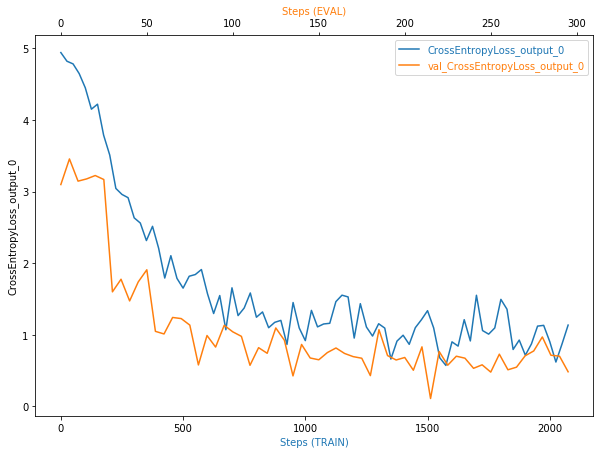

In [99]:
plot_tensor(trial, 'CrossEntropyLoss_output_0')

Looking at the graph above, we can see the two curves start off with higher cross entropy losses, but approach each other over time. The curves towards the later steps flatten out and follow each other mostly. If we had begun to see the loss curves straying farther away from each other, that would have been [a sign of overfitting](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/).

This also sheds some more light on how we can approach an issue that was displayed:
```
Overtraining: IssuesFound
```

This error can come up with when the model no longer improves (reduces loss/error) for some number of iterations. We can see in this graph that after roughly the 1250th step, both the training and calidation cross entropy lossed have mostly fluctuated between narrow range. If we further increase the number of training epochs, we might begin to see both losses rising up again as a rasut of overtraining. We can hopefully mitigate this problem by reducing the nummber of epochs. We can see that around the 1500th step (three-fourths of the way through the epochs), the losses are slightly lower. Therefore, we can estimate that we only need three-fourths as many epochs, or between 7 and 8. We'll round the number of epochs down to `7` (we'll fortunately see later that this does not drastically affect the accuracy of our model).

We'll now generate a graphic with some profiler data to shed light on the machines we were running our HPO and training algorithms on.

In [213]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

job = TrainingJob(job_name, region)
job.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-182946999348/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 7, "NumSteps": 1, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 5, "NumSteps": 1, }', 'FileOpenFailThreshold': '50', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 9, "NumSteps": 3, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760'}}
s3 path:s3://sagemaker-us-east-1-182946999348/pytorch-training-2022-02-12-06-25-08-858/profiler-output


Profiler data from system is available


In [214]:
# Display the profiler output
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = job.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader = None,
    select_dimensions = ['CPU', 'GPU'],
    select_events = ['total'],
)

[2022-02-12 10:10:54.879 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO metrics_reader_base.py:134] Getting 24 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'GPUUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1'}


**NOTE:** This image might not load in the notebook when opening. For convenience, an image can be accessed via the file `img/profiler_cpu_gpu_timeline.png`.

This diagram above sheds some light on a profiler rule violation that came up while running our `train_model.py` script:

```
LowGPUUtilization:IssuesFound
```

We can see that GPU usage is indeed low, mostly below the 20% mark. The Profiler Report, which I will briefly discuss below, does suggest two potential steps:
```
You may want to consider to either switch to a smaller instance type or to increase the batch size.
```

However, the AWS instance that we used to run `train_model.py` has one 1 GPU instance, so we cannot reduce it any further. We could use an instance that is completely CPU based, but we also need to consider that the training algorithm had been processing images. The fact that there were even spikes in GPU utilization suggests to me that we should still keep using at least one GPU instance when training this model. What we could do to hopefully fix this is to increase the `batch_size`. However, after attempting to train a model with an increased `batch_size` (I tried out two values: `64` and `128`), I got models that yielded accuracy of under 72%, which is nontrivially worse than my original model. In an ideal world, I would have been able to try out more different combinations of hyperparameters that would have revealed better results.

#### Profiler Report

The Profiler that we passed into our model also generated a report that shows some areas where our model and/or set up could improve on. 

In [102]:
rule_output_path = new_estimator.output_path + new_estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-182946999348/pytorch-training-2022-02-12-06-25-08-858/rule-output


In [103]:
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

2022-02-12 06:50:49     401962 pytorch-training-2022-02-12-06-25-08-858/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-02-12 06:50:48     254304 pytorch-training-2022-02-12-06-25-08-858/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-02-12 06:50:44        192 pytorch-training-2022-02-12-06-25-08-858/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-02-12 06:50:44      41308 pytorch-training-2022-02-12-06-25-08-858/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-02-12 06:50:44       1985 pytorch-training-2022-02-12-06-25-08-858/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-02-12 06:50:44        130 pytorch-training-2022-02-12-06-25-08-858/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-02-12 06:50:44       4062 pytorch-training-2022-02-12-06-25-08-858/rule-output/ProfilerReport/profiler-output/profiler-re

With the profile report downloaded, we can checkout some details of our trial, as well as ways to improve it. This gave some more context on the `LowGPUUtilization:IssuesFound` mentioned above, such as the fluctuating level of usage. 

**NOTE:** While some parts of the profile report are not able to easily render in this notebook, the report can be accessed via the file `profiler-report.html` (or `profiler-report.pdf`), and can be viewed on a browser tab.

## Final Adjustments Before Deploying

Having done some analysis on our trained model, we'll make a few changes to our hyperparameters, and then deploy it for image classification.

In [114]:
deploy_hyperparameters = { hp: value for hp, value in tuned_hyperparameters.items() if hp in ['batch-size', 'epochs', 'lr', 'num-classes'] }
deploy_hyperparameters['epochs'] = 7

deploy_hyperparameters

{'batch-size': 32,
 'epochs': 7,
 'lr': 0.00037518045557353297,
 'num-classes': 133}

Additionally, one issue that I ran into while deploying some earlier version of the model was the following error:

```
ModuleNotFoundError: No module named 'smdebug'
```

Since our model already went through the debugging process earlier while testing our model, we will copy over the model functions to a deployment-ready file with packages that can be recognized without any additional installation. 

In [138]:
# Create an estimator with the hyperparameters from the best estimator
deployed_estimator = PyTorch(
    entry_point = 'train_model_deploy.py',
    role = role,
    py_version = 'py36',
    framework_version = '1.8',
    instance_count = 1,
    hyperparameters = deploy_hyperparameters,
    instance_type = 'ml.g4dn.xlarge'
)

In [139]:
# Fit the new estimator
input_channels = {
    'train': f's3://{bucket}/data/train',
    'valid': f's3://{bucket}/data/valid',
    'test': f's3://{bucket}/data/test'
}

deployed_estimator.fit(input_channels, wait = True)

2022-02-12 08:59:25 Starting - Starting the training job...
2022-02-12 08:59:48 Starting - Launching requested ML instancesProfilerReport-1644656365: InProgress
......
2022-02-12 09:00:55 Starting - Preparing the instances for training......
2022-02-12 09:01:48 Downloading - Downloading input data.........
2022-02-12 09:03:10 Training - Downloading the training image..................
2022-02-12 09:06:14 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-12 09:06:15,159 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-02-12 09:06:15,178 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-02-12 09:06:18,197 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-02-12 09:06:18,687 sagemaker-training-toolkit INFO     Invoking user script
Tra

We can see that the test accuracy is roughly `77.272%`, which is close to the how well the previous model did with `10` epochs. This gives us assurance that our model is still accuracy with less iterations, while being less prone to overtraining! From a financial standpoint, this is also better as it took less billable time to train the model, and will cost less as well.

## Model Deploying

With our model finalized, we can now deploy it to an endpoint. To help process the image, we'll include some serializers, one to process the image data we'll send, and one to return our prediction in a processable format.

In [140]:
# Import any necesssary classes
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer
from PIL import Image

Now, it's finally time to deploy our model to an endpoint!

In [141]:
# Deploy the trained model to an endpoint
predictor = deployed_estimator.deploy(
    initial_instance_count = 1, 
    instance_type = 'ml.m5.xlarge',
    serializer = IdentitySerializer('image/jpeg'),
    deserializer = JSONDeserializer()
) 

-----!

With an endpoint created, we will go ahead and predict some images with our model. We'll first start of with a pre-existing Collie image from our test dataset.

In [174]:
# Feel free to change the image path here
image_path = './img/collie.jpg'

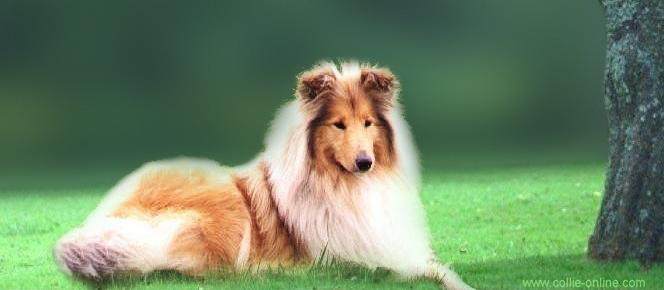

In [175]:
# Open and display the image
image = Image.open(image_path)
display(image)

We can actually simulate a new image by cropping parts of the image out, as done below:

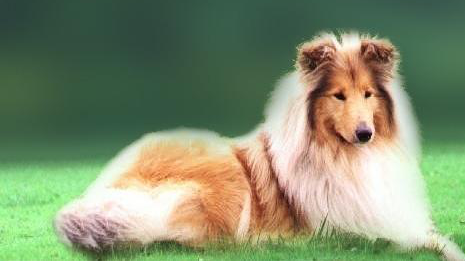

In [176]:
# Crop image
w, h = image.size
image = image.crop((0, 0.1 * h, 0.7 * w, h))

# Save image to new path
new_image_path_array = image_path.split('/')
new_image_path_array[-1] = f'cropped_{new_image_path_array[-1]}'
new_image_path = os.path.join(*new_image_path_array)

# Display cropped image
image.save(new_image_path, format = 'JPEG')
display(image)

Let's now send our image over to our endpoint.

In [194]:
# Read the image file
with open(new_image_path, 'rb') as f:
    img_payload = f.read()

# Run an prediction on the endpoint
response = predictor.predict(img_payload)
response

[[-7.3769307136535645,
  -1.6964266300201416,
  -7.350180625915527,
  -3.559257984161377,
  -4.242197036743164,
  -1.7687634229660034,
  -8.57789134979248,
  -10.132232666015625,
  -9.957161903381348,
  -9.04697322845459,
  -4.829838752746582,
  -1.428458333015442,
  -1.8108878135681152,
  -4.9028191566467285,
  -11.372970581054688,
  -9.8358154296875,
  -4.11880350112915,
  -9.05336856842041,
  -9.305254936218262,
  -7.741462230682373,
  -4.22502326965332,
  -1.7991321086883545,
  -5.428163051605225,
  -8.425088882446289,
  -16.095144271850586,
  -11.865531921386719,
  -11.616966247558594,
  -11.7780179977417,
  -5.373481273651123,
  -10.451316833496094,
  -4.155930042266846,
  -10.524863243103027,
  -7.073964595794678,
  -14.689393997192383,
  -11.41772747039795,
  -6.841071128845215,
  -8.021807670593262,
  -7.8810906410217285,
  -8.482748985290527,
  -11.318277359008789,
  -13.971283912658691,
  -5.439131736755371,
  -5.007443904876709,
  -14.345467567443848,
  -1.9115759134292603,

The output above is a list of cross entropy losses. The largest of those values will correspond to the test image's predicted label. We'll also need to add 1 to the result to account for the offset in indices.

In [195]:
# Note that Python list indices start at 0, but our label values start at 1
predicted_label = response[0].index(max(response[0])) + 1
predicted_label

54

We can use the DataFrame `df_breed_labels` from earlier to see the exact breed of the dog.

In [196]:
df_breed_labels.loc[[predicted_label]]

,breed
label,
54,Collie


Amazing! We can see that the predictor has properly classified the breed of the dog in the image.

Let's now try sending some brand new images (as long as there exists a class for that breed in our original dataset) to our endpoint. We'll first try sending an image of a German Shepherd found on [Wikipedia](https://en.wikipedia.org/wiki/German_Shepherd#/media/File:German-shepherd-4040871920.jpg).

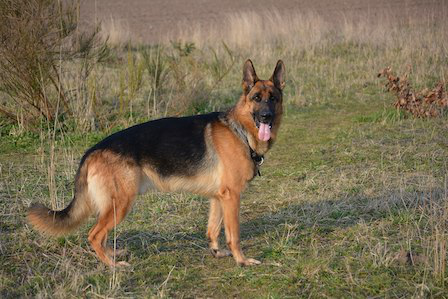

In [205]:
Image.open('./img/german_shepherd.jpg')

In [208]:
with open('./img/german_shepherd.jpg', 'rb') as f:
    img_payload_2 = f.read()

# Run an prediction on the endpoint
response_2 = predictor.predict(img_payload_2)
response_2

[[-10.67738151550293,
  -4.023644924163818,
  -2.9865362644195557,
  -7.189722061157227,
  -8.178300857543945,
  -13.004915237426758,
  -3.0770416259765625,
  -7.484673023223877,
  -6.993804454803467,
  -6.414844512939453,
  -1.7662144899368286,
  -4.916598796844482,
  -1.4256811141967773,
  -2.63857364654541,
  -4.753804683685303,
  -5.302852630615234,
  -10.605666160583496,
  -3.3523247241973877,
  -11.162793159484863,
  -1.131138563156128,
  -7.751373291015625,
  -3.27828311920166,
  -7.104593276977539,
  -15.557096481323242,
  -5.776843547821045,
  -10.40340518951416,
  -2.551967144012451,
  -4.833414554595947,
  -10.331948280334473,
  -6.249682426452637,
  -4.3052077293396,
  -9.308341979980469,
  -10.297079086303711,
  -6.926945686340332,
  -9.15432357788086,
  -6.831188201904297,
  -7.934328079223633,
  -7.198794364929199,
  -7.363468647003174,
  -11.595091819763184,
  -8.614785194396973,
  -6.382978439331055,
  -4.576158046722412,
  -8.0169038772583,
  -2.086176872253418,
  -8.

In [209]:
predicted_label_2 = response_2[0].index(max(response_2[0])) + 1
df_breed_labels.loc[[predicted_label_2]]

,breed
label,
71,German shepherd dog


Once again, our model has correctly identified the species of the dog! This indicates that we can procure completely new dog images and have some confidence in our model's predictions. Of course, our model will not always guess correctly. One particular example that I found are images of different breeds of retrievers. In the example below, we send over a new image of a Labrador Retriever, sourced from [UC Davis](https://vgl.ucdavis.edu/panel/labrador-retriever-health-panel-2).

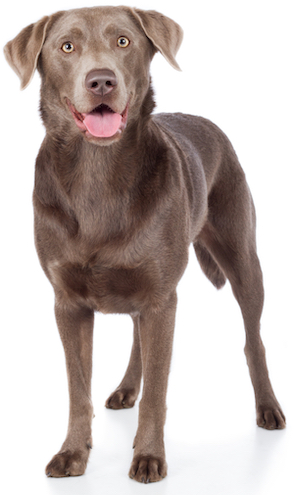

In [210]:
Image.open('./img/labrador.jpg')

In [211]:
with open('./img/labrador.jpg', 'rb') as f:
    img_payload_3 = f.read()

# Run an prediction on the endpoint
response_3 = predictor.predict(img_payload_3)
response_3

[[-14.011034965515137,
  -12.174448013305664,
  -6.7964067459106445,
  -7.826282024383545,
  -9.816486358642578,
  -15.46642780303955,
  -5.951972961425781,
  -5.035083770751953,
  -6.420684337615967,
  -4.923526763916016,
  -6.222522258758545,
  -13.33122444152832,
  -13.099181175231934,
  -7.5521392822265625,
  -11.33857250213623,
  -6.013184547424316,
  -17.604948043823242,
  -7.541658878326416,
  -10.14236068725586,
  -5.331641674041748,
  -12.156695365905762,
  -13.86344051361084,
  -13.740031242370605,
  -14.397261619567871,
  -9.049875259399414,
  -10.436639785766602,
  -6.6063127517700195,
  -6.9681620597839355,
  -15.705328941345215,
  -6.456708908081055,
  -11.969695091247559,
  -8.330669403076172,
  -13.275887489318848,
  -6.70495080947876,
  -5.925815105438232,
  -13.177168846130371,
  -6.459658145904541,
  -7.142607688903809,
  -4.6041259765625,
  -7.344062805175781,
  -4.902098655700684,
  -10.510786056518555,
  -6.434062480926514,
  -4.712981224060059,
  -9.1251478195190

In [212]:
predicted_label_3 = response_3[0].index(max(response_3[0])) + 1
df_breed_labels.loc[[predicted_label_3]]

,breed
label,
47,Chesapeake bay retriever


Looking at this prediction, we can see while the incorrect label is assigned, the guess is not too far off, as our model was still able to identify that the dog was a retriever. This is where looking at the actual breed name instead of just the label number can help us assess the accuracy of our model. Had we just looked at the label number, we would have dismissed our model's prediction as a completely incorrect guess.

After testing our endpoint with some images and verifying that it works, we'll need to delete our endpoint to avoid incurring any additional costs.

In [215]:
# Delete the endpoint when complete.
predictor.delete_endpoint()

From image dataset to trained model, we have successfully deployed our very own dog image classifer!